In [9]:
import os
os.chdir('..')

import torch
from torch import nn
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
from data_provider.data_loader import Dataset_ETT_hour
from torch.utils.data import DataLoader

dataset = Dataset_ETT_hour(
    root_path='./dataset/ETT-small/',
    data_path='ETTh1.csv',
    flag='train',
    size=[96, 48, 96],
    features='M',
    target='OT',
    timeenc=1,
    freq='h',
)

dataloader = DataLoader(
    dataset=dataset,
    batch_size=32,
    shuffle=False,
    num_workers=10,
    drop_last=True
)

FileNotFoundError: [Errno 2] No such file or directory: './dataset/ETT-small/ETTh1.csv'

In [ ]:
batch_x, batch_y, batch_x_mark, batch_y_mark = next(iter(dataloader))

batch_x.shape, batch_y.shape, batch_x_mark.shape, batch_y_mark.shape

(torch.Size([32, 96, 7]),
 torch.Size([32, 144, 7]),
 torch.Size([32, 96, 4]),
 torch.Size([32, 144, 4]))

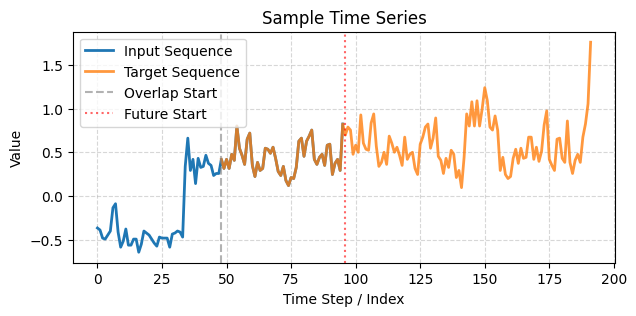

In [ ]:
from utils.plotters import plot_series

plot_series(batch_x[0,:,0].numpy(), batch_y[0,:,0].numpy(), label_len=48, label_x='Input Sequence', label_y='Target Sequence', title='Sample Time Series')

In [11]:
def FFT_for_Period(x, k=2):
    # [B, T, C]
    xf = torch.fft.rfft(x, dim=1)
    # find period by amplitudes
    frequency_list = abs(xf).mean(0).mean(-1)
    frequency_list[0] = 0
    _, top_list = torch.topk(frequency_list, k)
    top_list = top_list.detach().cpu().numpy()
    period = x.shape[1] // top_list
    return period, abs(xf).mean(-1)[:, top_list]

In [12]:
from layers.ema import Decomp

decomp = Decomp(alpha=0.1)

trend, season = decomp(batch_x)

trend.shape, season.shape

(torch.Size([32, 96, 7]), torch.Size([32, 96, 7]))

In [13]:
FFT_for_Period(season, k=3)

(array([96, 48, 32]),
 tensor([[22.9339,  8.8765,  5.9805],
         [22.5910,  8.6598,  5.5611],
         [22.4963,  8.8029,  5.4368],
         [22.1646,  8.6304,  5.0826],
         [21.9724,  8.6709,  4.9470],
         [21.5501,  8.8250,  4.7396],
         [20.5448,  9.3200,  4.4338],
         [19.7218,  9.5136,  4.5893],
         [20.3471,  8.4119,  3.8190],
         [21.2922,  9.2865,  4.7227],
         [20.3331,  9.2050,  4.3936],
         [19.6030,  9.3924,  4.5118],
         [19.9279,  9.7565,  4.9383],
         [19.0936,  9.6487,  4.9665],
         [18.9785,  9.9040,  5.2661],
         [18.5871,  9.9701,  5.4973],
         [18.9145, 10.6223,  5.9431],
         [18.1366, 10.5041,  5.9118],
         [16.7861,  9.8619,  5.5037],
         [16.5425,  9.9453,  5.7164],
         [16.4321, 10.0988,  5.9332],
         [16.2571, 10.2065,  6.0861],
         [15.9710, 10.2282,  6.1693],
         [15.6464, 10.1824,  6.2081],
         [14.6546,  9.6149,  5.8778],
         [14.5632,  9.6902, 

In [15]:
def FFT_for_Period_Per_Channel(x: torch.Tensor, k: int = 2):
    """
    针对每个样本的每个通道单独提取 Top-k 周期。
    
    Args:
        x: 输入张量 [B, T, C]
        k: 提取的显著周期数量
        
    Returns:
        period: 周期长度张量，形状 [B, k, C]
        amplitudes: 对应周期的幅值，形状 [B, k, C]
    """
    B, T, C = x.shape
    
    # 1. FFT 变换 [B, T, C] -> [B, L, C], L = T//2 + 1
    xf = torch.fft.rfft(x, dim=1)
    
    # 2. 计算幅值 [B, L, C]
    frequency_list = torch.abs(xf)
    
    # 3. 屏蔽直流分量 (Index 0)，防止除0错误和无意义的无穷大周期
    # 注意：这里是在 Frequency 维度 (dim=1) 操作
    frequency_list[:, 0, :] = 0
    
    # 4. 维度保护：防止 k 超过频域长度
    max_freq_len = frequency_list.shape[1]
    if k > max_freq_len:
        k = max_freq_len
        
    # 5. Top-k 选择
    # 在 dim=1 (频率轴) 上寻找幅值最大的 k 个点
    # top_vals: [B, k, C], top_inds: [B, k, C]
    top_vals, top_inds = torch.topk(frequency_list, k, dim=1)
    
    # 6. 计算周期
    # 逻辑防御：尽管屏蔽了 DC，若输入全为 0 可能仍会选到 index 0
    top_inds = top_inds.detach() # 索引通常不需要梯度
    top_inds[top_inds == 0] = 1  # 防止除以 0，设为 1 (周期为 T)
    
    period = T // top_inds
    
    # 建议返回 Tensor 以保持计算图连贯性，如果必须转 numpy 可在外部转换
    return period, top_vals

In [21]:
FFT_for_Period_Per_Channel(x=season[1, :, :].unsqueeze(0), k=3)

(tensor([[[96, 96, 96, 96, 96, 96, 96],
          [48, 48, 48, 48, 48, 24, 48],
          [24, 24, 24, 24, 32, 48, 32]]]),
 tensor([[[23.7228, 32.2066, 24.7544, 23.4613, 18.4914, 18.2033, 17.2970],
          [ 6.0818, 13.9529,  6.6327, 10.6383, 11.1321,  4.7881,  7.4522],
          [ 4.6652,  7.7375,  5.2086,  5.7238,  7.0264,  4.7289,  4.9235]]]))

In [22]:
def FFT_for_Period_Decomp(season_x: torch.Tensor, k: int = 2):
    """
    专门针对去趋势后的 Season 项进行周期提取。
    
    Args:
        season_x: 经过 Decomp 处理后的张量 [B, T, C]
        k: Top-k
    
    Returns:
        period: [B, k, C]
        amplitudes: [B, k, C]
    """
    B, T, C = season_x.shape
    
    # 1. FFT
    xf = torch.fft.rfft(season_x, dim=1)
    
    # 2. 计算幅值
    frequency_list = torch.abs(xf) # [B, L, C]
    
    # 3. 关键干预：屏蔽低频伪影
    # Index 0: 直流分量 (均值)，Decomp 后应该很小，但置 0 更安全
    frequency_list[:, 0, :] = 0
    
    # Index 1: 对应周期 = T (96)。
    # 既然是 Season 项，我们寻找的是"重复"模式。
    # 长度为 96 的波在 96 的窗口里只出现一次，无法确认其"周期性"（可能是残留趋势）。
    # 且受边界效应影响极大，必须屏蔽。
    frequency_list[:, 1, :] = 0
    
    # 4. 动态 Top-k
    # 现在的有效频率从 Index 2 (周期 48) 开始
    max_freq_len = frequency_list.shape[1]
    if k > max_freq_len:
        k = max_freq_len
        
    # 5. Top-k 选取
    top_vals, top_inds = torch.topk(frequency_list, k, dim=1)
    
    # 6. 转周期
    top_inds = top_inds.detach()
    # 此时 top_inds 最小也是 2，不会出现除 0 错误
    # 但为了代码健壮性，依然保留 safe mask
    top_inds[top_inds == 0] = 1 
    
    period = T // top_inds
    
    return period, top_vals

In [24]:
FFT_for_Period_Decomp(season[0, :, :].unsqueeze(0), k=3)

(tensor([[[48, 48, 48, 48, 48, 32, 48],
          [24, 32, 24, 32, 32, 24, 32],
          [32, 24, 32, 24, 19, 48, 24]]]),
 tensor([[[ 5.4208, 13.8783,  6.0588, 10.4935, 11.9087,  5.1763,  9.2932],
          [ 4.6872,  8.4026,  5.1642,  5.8942,  7.3841,  5.1062,  5.8213],
          [ 4.0262,  8.1409,  5.1589,  5.8404,  4.0406,  5.0822,  2.3234]]]))

In [ ]:
plt.figure(figsize=(10, 6))